In [23]:
import pandas as pd

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

In [24]:
# Evitar warnings
import warnings
warnings.filterwarnings("ignore")

In [25]:
# Cargar el dataset
df = pd.read_csv("processed\data_processed_final.csv")

In [26]:
def calculate_change_indices(df):
    change_indices = []
    for i in range(1, len(df)):
        if df.iloc[i]['last_performance'] != df.iloc[i-1]['last_performance']:
            change_indices.append(i)
    return change_indices


def plot_results(y, df_jugador, df_predictions, prediction_index):
    
    plt.figure(figsize=(12, 6))
    plt.plot(df_jugador['Fecha'], df_jugador[y], label='Real', color='blue')
    plt.plot(df_predictions[df_predictions['Predicciones'].notnull()]['Fecha'], df_predictions[df_predictions['Predicciones'].notnull()]['Predicciones'], label='Predicción', color='red')
    plt.scatter(df_jugador.iloc[prediction_index]['Fecha'], df_jugador.iloc[prediction_index][y], color='green', label='Día antes de predicción')
    plt.title(f'Predicción de {y} para el jugador {jugador}')
    plt.xlabel('Fecha')
    plt.ylabel(y)
    plt.legend()
    plt.grid(True)

    # Configurar el eje X para mostrar solo el nombre del mes
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Un mes por etiqueta
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Mostrar solo el nombre del mes (Ene, Feb, etc.)
    
    # Rotar las etiquetas del eje X para mayor legibilidad
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

def calculate_errors(df_jugador, df_predictions, y):
    aux = df_predictions[df_predictions['Predicciones'].notnull()]
    aux['Diferencia'] = abs(aux[y] - aux['Predicciones'])

    mean_error_todos = np.mean(aux['Diferencia'])
    std_error_todos = np.std(aux['Diferencia'])
    min_error_todos = np.min(aux['Diferencia'])
    max_error_todos = np.max(aux['Diferencia'])
    median_todos = np.median(aux['Diferencia'])

    change_indices = calculate_change_indices(df_jugador)

    match_days = df_jugador.iloc[np.array(change_indices)]['Fecha']
    errors_match_days = aux[aux['Fecha'].isin(match_days)]['Diferencia']

    mean_error_dia_partido = np.mean(errors_match_days)
    std_error_dia_partido = np.std(errors_match_days)
    min_error_dia_partido = np.min(errors_match_days)
    max_error_dia_partido = np.max(errors_match_days)
    median_dia_partido = np.median(errors_match_days)


    before_match_days = df_jugador.iloc[np.array(change_indices) - 1]['Fecha']
    errors_before_match_days = aux[aux['Fecha'].isin(before_match_days)]['Diferencia']

    mean_error_dia_antes_partido = np.mean(errors_before_match_days)
    std_error_dia_antes_partido = np.std(errors_before_match_days)
    min_error_dia_antes_partido = np.min(errors_before_match_days)
    max_error_dia_antes_partido = np.max(errors_before_match_days)
    median_dia_antes_partido = np.median(errors_before_match_days)

    print("______Todos los días____________")
    print(f"Mean error todos: {mean_error_todos}")
    print(f"Std error todos: {std_error_todos}")
    print(f"Min error todos: {min_error_todos}")
    print(f"Max error todos: {max_error_todos}")
    print(f"Median error todos: {median_todos}\n")

    print("______Días de partido___________")
    print(f"Mean error dia partido: {mean_error_dia_partido}")
    print(f"Std error dia partido: {std_error_dia_partido}")
    print(f"Min error dia partido: {min_error_dia_partido}")
    print(f"Max error dia partido: {max_error_dia_partido}")
    print(f"Median error dia partido: {median_dia_partido}\n")

    print("______Días antes de partido_____")
    print(f"Mean error dia antes partido: {mean_error_dia_antes_partido}")
    print(f"Std error dia antes partido: {std_error_dia_antes_partido}")
    print(f"Min error dia antes partido: {min_error_dia_antes_partido}")
    print(f"Max error dia antes partido: {max_error_dia_antes_partido}")
    print(f"Median error dia antes partido: {median_dia_antes_partido}")

In [27]:
def evaluate_model(df_jugador, config):
    '''
    Evaluar el modelo para un jugador con la configuración dada

    Parámetros:
    - df_jugador: DataFrame con los datos del jugador
    - config: Diccionario con la configuración del modelo
        - order: (p,d,q) del modelo SARIMA
        - seasonal_order: (P,D,Q,s) del modelo SARIMA
        - y: Serie a predecir
        - exog: Serie exógena
        - exog_options: Opciones de la serie exógena:
            - 'no_future': No se incluyen los datos futuros. Propaga el último valor conocido
        - pred_options: Opciones de predicción: 
            - 'matches': Predice los días de partido
            - 'one': Predice a partir de un día hasta el final
            - 'step': Predice cada n días
        - step_options: Si pred_options es 'matches', opciones de predicción:
            - 'next_match': Predice los días hasta el siguiente partido
            - 'next_day': Predice solo un día (el del partido)
        - train_size: Si pred_options es 'one', porcentaje de datos a partir del cual se empieza a predecir
        - step: Si pred_options es 'step', cada cuántos días se predice y número de días a predecir

    Devuelve:
    - df_predictions: DataFrame con las predicciones
    '''

    order = config['order']
    seasonal_order = config['seasonal_order']
    y = config['y']
    exog = config['exog']
    exog_options = config['exog_options']
    
    df_predictions = df_jugador[['Fecha', y]].copy()
    df_predictions['Predicciones'] = np.nan
    
    
    if config['pred_options'] == 'matches':
        match_indices = calculate_change_indices(df_jugador)

        for i in range(len(match_indices)-1):
            matchday = match_indices[i]
            next_matchday = match_indices[i+1]

            train_data = df_jugador.iloc[:matchday]
            test_data = df_jugador.iloc[matchday:]
            
            days_to_next_match = next_matchday - matchday
            
            modelo = SARIMAX(train_data[y], 
                                exog=train_data[exog],
                                order=order, seasonal_order=seasonal_order)

            resultado = modelo.fit()
            
            if config['step_options'] == 'next_match':
                predicciones = resultado.predict(start=matchday, end=next_matchday-1,
                                                exog=test_data[exog][:days_to_next_match], dynamic=False)
                
                if exog_options == 'no_future':
                    pred_exog = [train_data.iloc[-1][exog]]*days_to_next_match
                    
                    predicciones = resultado.predict(start=matchday, end=next_matchday-1,
                                                exog=pred_exog, dynamic=False)
                
                df_predictions.iloc[matchday:next_matchday, df_predictions.columns.get_loc('Predicciones')] = predicciones

            elif config['step_options'] == 'next_day':
                # Solo se predice un día
                predicciones = resultado.predict(start=matchday, end=matchday,
                                                exog=test_data[exog][:1], dynamic=False)
                
                if exog_options == 'no_future':
                    pred_exog = [train_data.iloc[-1][exog]]
                    
                    predicciones = resultado.predict(start=matchday, end=matchday,
                                                exog=pred_exog, dynamic=False)
            
                df_predictions.iloc[matchday, df_predictions.columns.get_loc('Predicciones')] = predicciones.iloc[0]

        
        if config['step_options'] == 'next_day':        
            # Rellenar los valores nulos con el último valor conocido
            df_predictions['Predicciones'] = df_predictions['Predicciones'].fillna(method='ffill')
        
        prediction_index = np.array(match_indices) - 1


    elif config['pred_options'] == 'one':
        i = int(len(df_jugador)*config['train_size'])
        train_data = df_jugador[:i]
        test_data = df_jugador[i:]  

        modelo = SARIMAX(train_data[y], order=order, seasonal_order=seasonal_order, exog=train_data[exog])

        resultado = modelo.fit()

        predicciones = resultado.predict(start=i, end=len(df_jugador)-1, exog=test_data[exog], dynamic=False)

        if exog_options == 'no_future':
            pred_exog = [train_data.iloc[-1][exog]]*len(test_data)
            
            predicciones = resultado.predict(start=i, end=len(df_jugador)-1, exog=pred_exog, dynamic=False)

        df_predictions.iloc[i:, df_predictions.columns.get_loc('Predicciones')] = predicciones

        prediction_index = i -1
    
    elif config['pred_options'] == 'step':
        step = config['step']
        
        for i in range(2, len(df_jugador)-step+1, step):
            train_data = df_jugador[:i]
            
            modelo = SARIMAX(train_data[y], order=order, seasonal_order=seasonal_order, exog=train_data[exog])

            resultado = modelo.fit()

            predicciones = resultado.forecast(steps=step, exog=df_jugador[exog][i:i+step])

            if exog_options == 'no_future':
                pred_exog = [train_data.iloc[-1][exog]]*step
                
                predicciones = resultado.forecast(steps=step, exog=pred_exog)
            
            df_predictions.iloc[i:i+step, df_predictions.columns.get_loc('Predicciones')] = predicciones

        prediction_index = np.arange(2, len(df_jugador)-step+1, step) -1
        
    plot_results(y, df_jugador, df_predictions, prediction_index)
    calculate_errors(df_jugador, df_predictions, y)


def evaluate_model_no_exog(df_jugador, config):
    
    order = config['order']
    seasonal_order = config['seasonal_order']
    y = config['y']
    
    df_predictions = df_jugador[['Fecha', y]].copy()
    df_predictions['Predicciones'] = np.nan
    
    
    if config['pred_options'] == 'matches':
        match_indices = calculate_change_indices(df_jugador)

        for i in range(len(match_indices)-1):
            matchday = match_indices[i]
            next_matchday = match_indices[i+1]

            train_data = df_jugador.iloc[:matchday]
            
            modelo = SARIMAX(train_data[y], order=order, seasonal_order=seasonal_order)

            resultado = modelo.fit()
            
            if config['step_options'] == 'next_match':
                predicciones = resultado.predict(start=matchday, end=next_matchday-1, dynamic=False)
                
                df_predictions.iloc[matchday:next_matchday, df_predictions.columns.get_loc('Predicciones')] = predicciones

            elif config['step_options'] == 'next_day':
                # Solo se predice un día
                predicciones = resultado.predict(start=matchday, end=matchday, dynamic=False)
            
                df_predictions.iloc[matchday, df_predictions.columns.get_loc('Predicciones')] = predicciones.iloc[0]

        
        if config['step_options'] == 'next_day':        
            # Rellenar los valores nulos con el último valor conocido
            df_predictions['Predicciones'] = df_predictions['Predicciones'].fillna(method='ffill')
        
        prediction_index = np.array(match_indices) - 1


    elif config['pred_options'] == 'one':
        i = int(len(df_jugador)*config['train_size'])
        train_data = df_jugador[:i]
        test_data = df_jugador[i:]  

        modelo = SARIMAX(train_data[y], order=order, seasonal_order=seasonal_order)

        resultado = modelo.fit()

        predicciones = resultado.predict(start=i, end=len(df_jugador)-1, dynamic=False)

        df_predictions.iloc[i:, df_predictions.columns.get_loc('Predicciones')] = predicciones

        prediction_index = i -1
    
    elif config['pred_options'] == 'step':
        step = config['step']
        
        for i in range(2, len(df_jugador)-step+1, step):
            train_data = df_jugador[:i]
            
            modelo = SARIMAX(train_data[y], order=order, seasonal_order=seasonal_order)

            resultado = modelo.fit()

            predicciones = resultado.forecast(steps=step)
            
            df_predictions.iloc[i:i+step, df_predictions.columns.get_loc('Predicciones')] = predicciones

        prediction_index = np.arange(2, len(df_jugador)-step+1, step) -1
        
    plot_results(y, df_jugador, df_predictions, prediction_index)
    calculate_errors(df_jugador, df_predictions, y)

### Ferrán

Un orden (1,1,1) con un periodo de estacionalidad 15 (como en su serie de rendimiento), nos devuelve los mejores resultados

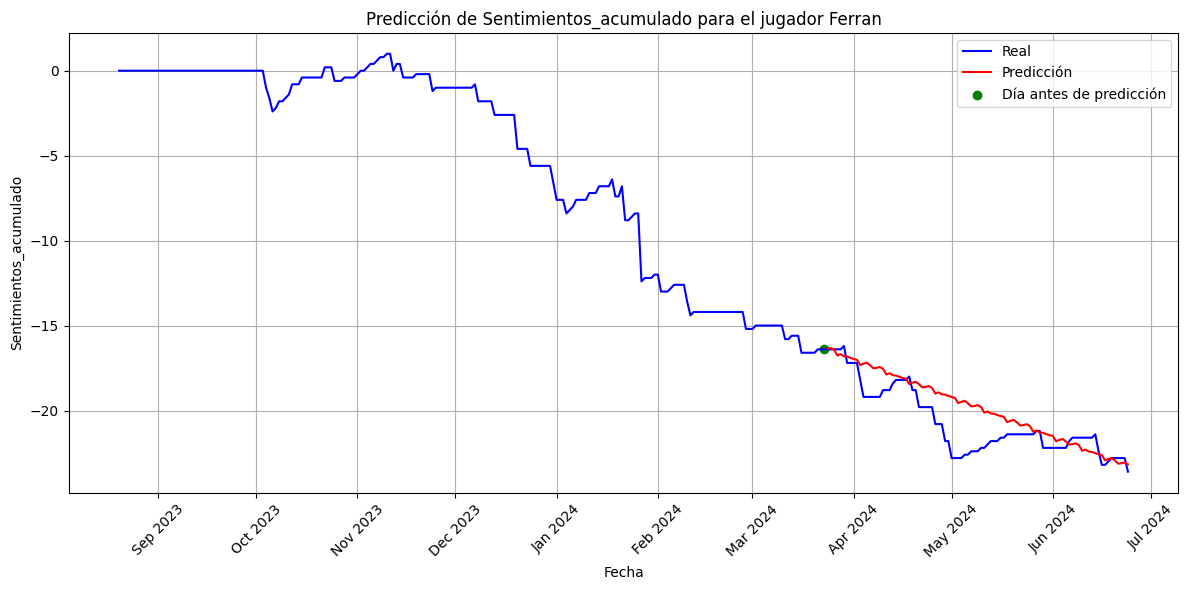

______Todos los días____________
Mean error todos: 1.0437796160251462
Std error todos: 0.9321074660425159
Min error todos: 0.0021028099862760996
Max error todos: 3.5960513443217152
Median error todos: 0.7135589435168832

______Días de partido___________
Mean error dia partido: 1.0325499354848613
Std error dia partido: 0.9953812952917969
Min error dia partido: 0.11910698272690468
Max error dia partido: 3.312888457252516
Median error dia partido: 0.4756952805455654

______Días antes de partido_____
Mean error dia antes partido: 1.1037216517734119
Std error dia antes partido: 0.8823049676084721
Min error dia antes partido: 0.0021028099862760996
Max error dia antes partido: 3.2367469480902145
Median error dia antes partido: 0.9918546179511836


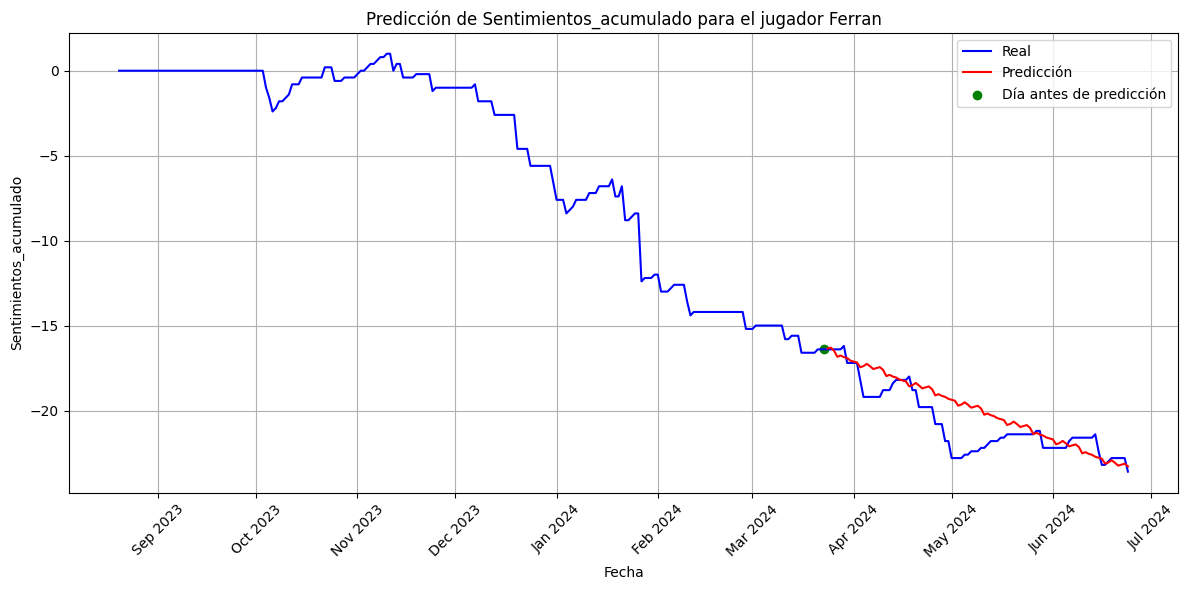

______Todos los días____________
Mean error todos: 0.9873412203400005
Std error todos: 0.9025365942007819
Min error todos: 0.014344213392909921
Max error todos: 3.430149608714906
Median error todos: 0.6129827591813282

______Días de partido___________
Mean error dia partido: 0.9644170152938193
Std error dia partido: 0.9507001794562868
Min error dia partido: 0.014344213392909921
Max error dia partido: 3.1516531597644963
Median error dia partido: 0.39816115965519927

______Días antes de partido_____
Mean error dia antes partido: 1.0648063603576325
Std error dia antes partido: 0.8416000660052197
Min error dia antes partido: 0.02344632222760623
Max error dia antes partido: 3.0853475657818237
Median error dia antes partido: 0.8974697786204935


In [29]:
players = df['Player'].unique()

jugador = players[0]
df_jugador = df[df['Player'] == jugador]
df_jugador['Fecha'] = pd.to_datetime(df_jugador['Fecha'])

config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,15),
    'y': 'Sentimientos_acumulado',
    'exog': 'last_performance',
    'exog_options': 'no_future',
    'pred_options': 'one',
    'train_size' : 0.7
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

###

In [31]:
jugador = players[1]
df_jugador = df[df['Player'] == jugador]
df_jugador['Fecha'] = pd.to_datetime(df_jugador['Fecha'])

config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,70),
    'y': 'Sentimientos_acumulado',
    'exog': 'last_performance',
    'exog_options': 'no_future',
    'pred_options': 'matches',
    'step_options': 'next_match'
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

KeyboardInterrupt: 